In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./autoscout24-germany-dataset.csv")
df.head()

mileage        make   model      fuel    gear offerType  price     hp  year
0   235000         BMW     316    Diesel  Manual      Used   6800  116.0  2011
1    92800  Volkswagen    Golf  Gasoline  Manual      Used   6877  122.0  2011
2   149300        SEAT    Exeo  Gasoline  Manual      Used   6900  160.0  2011
3    96200     Renault  Megane  Gasoline  Manual      Used   6950  110.0  2011
4   156000     Peugeot     308  Gasoline  Manual      Used   6950  156.0  2011

The main objective of this notebook is to demonstrate different linear predictive models and predict the cost of cars based on data gathered from Germany.

# Getting familiar with the data 

In [3]:
df.shape

(46405, 9)

In [4]:
df.describe()

mileage         price            hp          year
count  4.640500e+04  4.640500e+04  46376.000000  46405.000000
mean   7.117786e+04  1.657234e+04    132.990987   2016.012951
std    6.262531e+04  1.930470e+04     75.449284      3.155214
min    0.000000e+00  1.100000e+03      1.000000   2011.000000
25%    1.980000e+04  7.490000e+03     86.000000   2013.000000
50%    6.000000e+04  1.099900e+04    116.000000   2016.000000
75%    1.050000e+05  1.949000e+04    150.000000   2019.000000
max    1.111111e+06  1.199900e+06    850.000000   2021.000000

Now we see the unique values for some of our columns

In [5]:
df['fuel'].unique()

array(['Diesel', 'Gasoline', 'Electric/Gasoline', '-/- (Fuel)',
       'Electric', 'Electric/Diesel', 'CNG', 'LPG', 'Others', 'Hydrogen',
       'Ethanol'], dtype=object)

In [6]:
df['gear'].unique()

array(['Manual', 'Automatic', nan, 'Semi-automatic'], dtype=object)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46405 entries, 0 to 46404
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    46405 non-null  int64  
 1   make       46405 non-null  object 
 2   model      46262 non-null  object 
 3   fuel       46405 non-null  object 
 4   gear       46223 non-null  object 
 5   offerType  46405 non-null  object 
 6   price      46405 non-null  int64  
 7   hp         46376 non-null  float64
 8   year       46405 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.2+ MB


Thus there are some null values in the columns model, gear, and hp. Let's count how many are there.

# Data cleaning

In [8]:
df.isna().sum()

mileage        0
make           0
model        143
fuel           0
gear         182
offerType      0
price          0
hp            29
year           0
dtype: int64

Since the number of missing values is less than 1% of our total data, I presume it'll be okay if we drop these entries.

In [9]:
df.dropna(inplace = True)

In [10]:
#dropping duplicate rows
df.drop_duplicates(keep = 'first', inplace = True)

In [11]:
#now let's see the shape of our dataframe
df.shape

(43947, 9)

In [12]:
df.describe()

mileage         price            hp          year
count  4.394700e+04  4.394700e+04  43947.000000  43947.000000
mean   7.231258e+04  1.654656e+04    133.624571   2015.931349
std    6.217336e+04  1.944680e+04     75.049853      3.120073
min    0.000000e+00  1.100000e+03      1.000000   2011.000000
25%    2.150000e+04  7.490000e+03     86.000000   2013.000000
50%    6.130900e+04  1.099000e+04    116.000000   2016.000000
75%    1.060000e+05  1.949000e+04    150.000000   2019.000000
max    1.111111e+06  1.199900e+06    850.000000   2021.000000

Adding an Age column

In [13]:
from datetime import datetime

In [14]:
df['age'] = datetime.now().year - df['year']

In [15]:
df.drop('year',axis = 1, inplace = True)

In [16]:
df.head()

mileage        make   model      fuel    gear offerType  price     hp  age
0   235000         BMW     316    Diesel  Manual      Used   6800  116.0   10
1    92800  Volkswagen    Golf  Gasoline  Manual      Used   6877  122.0   10
2   149300        SEAT    Exeo  Gasoline  Manual      Used   6900  160.0   10
3    96200     Renault  Megane  Gasoline  Manual      Used   6950  110.0   10
4   156000     Peugeot     308  Gasoline  Manual      Used   6950  156.0   10

# Exploratory Data Analysis

In [17]:
M = df.price.median()
M

10990.0

In [18]:
m = df.price.mean()
m

16546.56379275036

In [19]:
below_M = df.query("price<10990")
no_below_M = below_M.value_counts().sum()

above_M = df.query("price > 10990.1")
no_above_M = above_M.value_counts().sum()

print(f'Median = {M}')
print('Number of cars with values above the median')
print(no_above_M)
print('Number of cars with values below the median')
print(no_below_M)
print('--------------------------------------------')

below_m = df.query("price<16546")
no_below_m = below_m.value_counts().sum()

above_m = df.query("price > 16546.1")
no_above_m = above_m.value_counts().sum()

print(f'Median = {m}')
print('Number of cars with values above the mean')
print(no_above_m)
print('Number of cars with values below the mean')
print(no_below_m)

Median = 10990.0
Number of cars with values above the median
21846
Number of cars with values below the median
21807
--------------------------------------------
Median = 16546.56379275036
Number of cars with values above the mean
13450
Number of cars with values below the mean
30497


<AxesSubplot:xlabel='hp', ylabel='price'>

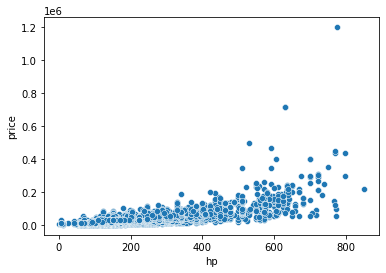

In [20]:
sns.scatterplot(x=df['hp'], y=df['price'])

In [21]:
#Changing the fuels
df['fuel'] = df['fuel'].replace('Diesel', 0)
df['fuel'] = df['fuel'].replace('Gasoline', 1)
df['fuel'] = df['fuel'].replace(['Electric/Gasoline', 'Electric/Diesel', 'Electric'],  2)
df['fuel'] = df['fuel'].replace(['CNG', 'LPG', 'Others', '-/- (Fuel)', 'Ethanol', 'Hydrogen'], 3)

In [22]:
df.fuel.unique()

array([0, 1, 2, 3])

Correlation heatmap

<AxesSubplot:>

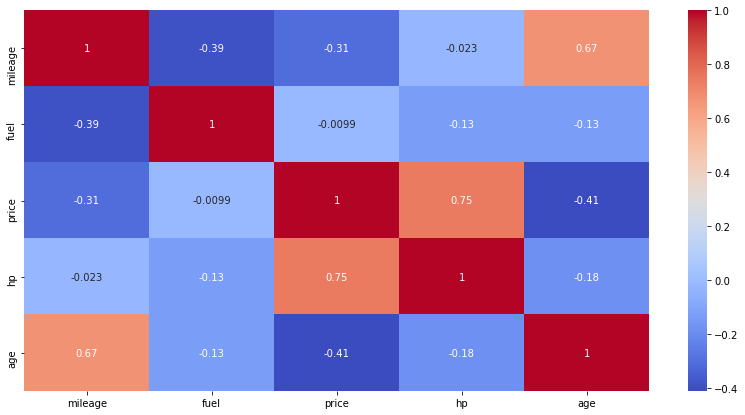

In [23]:
plt.figure(figsize=(14,7))
sns.heatmap(df.corr(),annot=True, cmap='coolwarm')

We find the popular cars

In [24]:
min_price, max_price = df.price.quantile([0.01, 0.99])
min_price, max_price

(3300.0, 83468.84000000004)

In [25]:
pop_cars = df[(df.price<max_price) & (df.price>min_price)]
print('Total number of cars:')
print(df.shape[0])
print('---------------------')
print('Numers of cars that are abore $3.300,0 and below $99.999,0')
print(pop_cars.shape[0])

Total number of cars:
43947
---------------------
Numers of cars that are abore $3.300,0 and below $99.999,0
43044


In [26]:
min_price, max_price = df.mileage.quantile([0.01, 0.99])
min_price, max_price

(7.0, 259170.56000000006)

In [27]:
pop_cars = pop_cars[(pop_cars.mileage<max_price) & (pop_cars.mileage>min_price)]

In [28]:
min_price, max_price = df.hp.quantile([0.01, 0.999])
min_price, max_price

(60.0, 650.0)

In [29]:
pop_cars = pop_cars[(pop_cars.hp<max_price) & (pop_cars.hp>min_price)]

In [30]:
pop_cars['fuel'] = pop_cars['fuel'].replace(0, 'Diesel')
pop_cars['fuel'] = pop_cars['fuel'].replace(1, 'Gasoline')
pop_cars['fuel'] = pop_cars['fuel'].replace(2, 'Electric')
pop_cars['fuel'] = pop_cars['fuel'].replace(3, 'Others')

In [31]:
pop_cars = pop_cars.reset_index(drop=True)

# One hot encoding and K-Folds

In [32]:
pop_cars = pop_cars.drop(columns=['make', 'model'], axis=1)
pop_cars.head()

mileage      fuel    gear offerType  price     hp  age
0   235000    Diesel  Manual      Used   6800  116.0   10
1    92800  Gasoline  Manual      Used   6877  122.0   10
2   149300  Gasoline  Manual      Used   6900  160.0   10
3    96200  Gasoline  Manual      Used   6950  110.0   10
4   156000  Gasoline  Manual      Used   6950  156.0   10

In [33]:
pop_cars.dtypes.value_counts()

object     3
int64      3
float64    1
dtype: int64

In [34]:
mask = pop_cars.dtypes == np.object
categorical = pop_cars.columns[mask]
categorical

Index(['fuel', 'gear', 'offerType'], dtype='object')

In [35]:
num_ohc_cols = (pop_cars[categorical].apply(lambda x: x.nunique()).sort_values(ascending=False))
num_ohc_cols

offerType    5
fuel         4
gear         3
dtype: int64

In [36]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

data_ohc = pop_cars.copy()

ohc = OneHotEncoder()

for col in num_ohc_cols.index:
  #this is a sparse array
  new_dat = ohc.fit_transform(data_ohc[[col]])
  #drop original column from original DF
  data_ohc = data_ohc.drop(col, axis=1)
  #get unique names of columns
  cats = ohc.categories_
  #create a column for each OHE column by value
  new_cols = ['_'.join([col,cat]) for cat in cats[0]]
  #create the new Dataset
  new_df = pd.DataFrame(new_dat.toarray(), columns=new_cols)
  #append new data to df
  data_ohc=pd.concat([data_ohc, new_df], axis=1)

y_col = 'price'

feature_cols = [x for x in data_ohc.columns if x != y_col]

X = data_ohc[feature_cols]
y = data_ohc[y_col]

In [37]:
X.head()

mileage     hp  age  offerType_Demonstration  offerType_Employee's car  \
0   235000  116.0   10                      0.0                       0.0   
1    92800  122.0   10                      0.0                       0.0   
2   149300  160.0   10                      0.0                       0.0   
3    96200  110.0   10                      0.0                       0.0   
4   156000  156.0   10                      0.0                       0.0   

   offerType_New  offerType_Pre-registered  offerType_Used  fuel_Diesel  \
0            0.0                       0.0             1.0          1.0   
1            0.0                       0.0             1.0          0.0   
2            0.0                       0.0             1.0          0.0   
3            0.0                       0.0             1.0          0.0   
4            0.0                       0.0             1.0          0.0   

   fuel_Electric  fuel_Gasoline  fuel_Others  gear_Automatic  gear_Manual  \
0            0.0            0.0          0.0             0.0          1.0   
1            0.0            1.0          0.0             0.0          1.0   
2            0.0            1.0          0.0             0.0          1.0   
3            0.0            1.0          0.0             0.0          1.0   
4            0.0            1.0          0.0             0.0          1.0   

   gear_Semi-automatic  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0

In [38]:
from sklearn.model_selection import KFold

kf = KFold(shuffle=True, random_state=72018, n_splits=3)

kf.split(X)

<generator object _BaseKFold.split at 0x7fa605022660>

This creates a Tuple, for 3 different scenarios(n_plits), that is: train_index, test_index

In [39]:
for train_index, test_index in kf.split(X):
  print("Train index:", train_index[:10], len(train_index))
  print("Test index:", test_index[:10], len(test_index))
  print('')

Train index: [ 0  2  4 10 11 12 13 16 19 20] 26924
Test index: [ 1  3  5  6  7  8  9 14 15 17] 13463

Train index: [0 1 2 3 4 5 6 7 8 9] 26925
Test index: [11 12 13 16 19 20 23 26 32 37] 13462

Train index: [ 1  3  5  6  7  8  9 11 12 13] 26925
Test index: [ 0  2  4 10 24 29 33 34 43 45] 13462



# Modeling

Linear regression without regularization

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
  X_train, X_test, y_train, y_test = (X.iloc[train_index, :], X.iloc[test_index, :], y[train_index], y[test_index])
  
  lr.fit(X_train, y_train)

  y_pred = lr.predict(X_test)

  score = r2_score(y_test.values, y_pred)

  scores.append(score)

scores

[0.8287930876292234, 0.8297633896297357, 0.8390539858927717]

Linear regression with Regularization

In [41]:
from sklearn.preprocessing import StandardScaler

scores = []
lr = LinearRegression()
s = StandardScaler()

for train_index, test_index in kf.split(X):
  X_train, X_test, y_train, y_test = (X.iloc[train_index, :], X.iloc[test_index, :], y[train_index], y[test_index])
  
  X_train_s = s.fit_transform(X_train)
  
  lr.fit(X_train_s, y_train)

  X_test_s = s.transform(X_test)

  y_pred = lr.predict(X_test_s)

  score = r2_score(y_test.values, y_pred)

  scores.append(score)

scores

[0.8287665996258867, 0.829763389629736, 0.8390557075678731]

Linear Regression with Regu, Pipeline com Cross Val Predict

In [44]:
# doing what we did above with Pipeline
from sklearn.pipeline import Pipeline

estimator = Pipeline([('scaler', s), ('linear_reg', lr)])

estimator.fit(X_train, y_train)

estimator.predict(X_test)

array([  337.54394193,  7509.40035959,  6646.10113076, ...,
       30315.43070237, 16273.01217139, 19866.976231  ])

In [45]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [46]:
from sklearn.model_selection import cross_val_predict

predictions = cross_val_predict(estimator, X, y, cv=kf, verbose=100)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [47]:
len(predictions)

40387

In [48]:
r2_score(y, predictions)

0.8326247491666151

In [49]:
np.mean(scores)

0.832528565607832

We can see that this is almost the same. Linear Regression doestn change much with Regularization

# Linear Regression with Polynomial Regularization

In [50]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

polis = [2, 3, 4]

lr1 = LinearRegression()

scores = []

for poli in polis:
  pf = PolynomialFeatures(poli)

  estimator = Pipeline([('make_higher_degree', pf), ('linear_reg', lr1)])

  predictions = cross_val_predict(estimator, X, y, cv=kf, verbose=100)

  score = r2_score(y, predictions)

  scores.append(score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3

In [51]:
list(zip(polis, scores))

[(2, 0.8834636269383815), (3, 0.816677589576142), (4, -1026.6737588070525)]